This file works primarily to query information about fume hood usage on campus. Calculating fume hood energy usage can be roughly simplified by the following formula:

BTU/hr = 1.08 * CFM * (Th-Tl)

CFM represents the cubic feet per minute of air passing through a fume hood. Th is the temperature of the room, Tl is the temperature of outdoors. We will update this script for fume hood energy usage during periods of cooling later.

In [1]:
import pandas as pd
import numpy as np
# import datetime
from datetime import datetime, timezone
import requests
import json
import matplotlib.pyplot as plt
import math
import scipy.stats as st

In [2]:
def create_tuple(response):
    # all data
    response_data = response.json()
    # print(response_data)
    # data for a single target
    response_datum = response_data[0]
    # print(response_datum)
    # the target - e.g. "120MapleAve.STM.M22-V/AverageMassFlow"
    response_target = response_datum['target']
    # the metric for this target - e.g. "Steam"
    #response_metric = response_datum['metric']
    # print(response_metric)
    # the datapoints as a list of lists
    response_datapoints = response_datum['datapoints']
    # print(response_datapoints)
    # array of tuples for numpy
    tuple_array = [tuple(x) for x in response_datapoints]
    # make a numpy array
    npa = np.array(tuple_array, dtype=[
                   ('value', np.double), ('ts', 'datetime64[ms]')])
    # npa = npa.astype([('value', np.double), ('ts', datetime)])

    # print("here")
    # for index, i in enumerate(npa):
    #   j = pd.to_datetime(i[1]).replace(tzinfo=timezone.utc).astimezone(tz="America/New_York")
    #   npa[index][1] = j
    return npa

In [3]:
def current_date():
    return str(datetime.now())

In [4]:
"""
Returns an array of tuples where tuple[0] is the metric, and tuple[1] is the time 
of measurement

Target: a WebCTRL point name in the form of a string 
Example: "#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/zone/zone_temp/trend_log"

Server: a string representing the WebCTRL server our point exists in
Example: "biotech_main"

Start: the start time we wish to be querying data about (in string format)
Example: "2021-12-31T11:00Z"

End: The end time we wish to be querying data about
Example: "2022-12-31T11:00Z"
"""
def fume_query(target,server, start,end):
  url = "https://ypsu0n34jc.execute-api.us-east-1.amazonaws.com/dev/query"
  data = {
      "range": {
        "from": start,
        "to": end,
      },
      "targets": [
        {
          "payload": {
            "schema": server,
          },
          "target": target
        }
      ],

    }
  request = requests.post(url, json=data)
  print(request)
  # print(request.json())
  return create_tuple(request)

# fume_query(target="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash", server="biotech_main", start="2021-12-25T00:00:00.000", end=current_date())
# fume_query(target="#baker_west_lab_120/occ_sensor_trend", server="endowed_main", start="2021-12-25T00:00:00.000", end=current_date())

# fume_query(target="#lstb_b-07_north/fh_sash_pos", server="weill_main", start="2022-10-22T11:00Z", end="2022-10-22T11:05Z")
# fume_query(target="#baker_west_lab_120/fh_sash_pos", server="endowed_main", start="2022-10-10T11:00Z", end="2022-10-22T11:05Z")

In [5]:
"""
Returns a time series of the ithaca air temperature over the respective 
"""

def outside_temp(start,end):
  # https://ypsu0n34jc.execute-api.us-east-1.amazonaws.com/dev/query doesn't work
  # https://portal.emcs.cornell.edu/api/datasources/proxy/5/query works
  # https://portal-api.emcs.cucloud.net/query works
  url = "https://portal-api.emcs.cucloud.net/query"
  target = "GameFarmRoadWeatherStation.TAVG_H_F"
  data = {
    "range": {
        "from": start,
        "to": end
    },
    "targets": [
        {
            "target": target,
        }
    ]
  }
  request = requests.post(url, json=data)
  print(request)
#   print(request.json())
  return create_tuple(request)

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
CFM List:  2022-11-17 05:00:00    224.13
2022-11-17 05:05:00    224.13
2022-11-17 05:10:00    224.13
2022-11-17 05:15:00    225.10
2022-11-17 05:20:00    225.10
                        ...  
2022-11-19 04:35:00    224.13
2022-11-19 04:40:00    225.59
2022-11-19 04:45:00    227.06
2022-11-19 04:50:00    227.06
2022-11-19 04:55:00    221.20
Length: 576, dtype: float64
CFM List new:  2022-11-17 05:00:00    224.13
2022-11-17 05:05:00    224.13
2022-11-17 05:10:00    224.13
2022-11-17 05:15:00    225.10
2022-11-17 05:20:00    225.10
                        ...  
2022-11-19 04:35:00    224.13
2022-11-19 04:40:00    225.59
2022-11-19 04:45:00    227.06
2022-11-19 04:50:00    227.06
2022-11-19 04:55:00    221.20
Length: 576, dtype: float64

Sash List:  2022-11-17 05:00:00    1.2
2022-11-17 05:05:00    1.2
2022-11-17 05:10:00    1.2
2022-11-17 05:15:00    1.2
2022-11-17 05:20:00    1.2
                      ...

,cfm,sash,occ,internal temp,external temp
2022-11-17 00:00:00,NaN,NaN,NaN,NaN,37.6286
2022-11-17 01:00:00,NaN,NaN,NaN,NaN,37.1696
2022-11-17 02:00:00,NaN,NaN,NaN,NaN,36.5900
2022-11-17 03:00:00,NaN,NaN,NaN,NaN,36.2030
2022-11-17 04:00:00,NaN,NaN,NaN,NaN,36.1958
...,...,...,...,...,...
2022-11-19 04:35:00,224.13,1.2,0.0,70.3,NaN
2022-11-19 04:40:00,225.59,1.2,0.0,70.3,NaN
2022-11-19 04:45:00,227.06,1.2,0.0,70.2,NaN
2022-11-19 04:50:00,227.06,1.2,0.0,70.2,NaN


,cfm,sash,occ,internal temp,external temp
2022-11-17 05:00:00,224.13,1.2,1.0,72.2,35.9762
2022-11-17 06:00:00,222.66,1.2,0.0,72.2,35.3840
2022-11-17 07:00:00,227.55,1.2,0.0,71.1,34.8314
2022-11-17 08:00:00,224.13,1.2,0.0,70.7,34.5938
2022-11-17 09:00:00,226.57,1.2,0.0,70.4,34.2158
2022-11-17 10:00:00,220.71,1.2,0.0,70.4,33.4256
2022-11-17 11:00:00,226.08,1.2,1.0,70.2,32.3528
2022-11-17 12:00:00,222.17,1.2,0.0,71.2,32.4500
2022-11-17 13:00:00,223.15,1.2,1.0,72.2,33.1556
2022-11-17 14:00:00,223.15,1.2,1.0,72.0,34.4642


,cfm,sash,occ,internal temp,external temp,BTUh
2022-11-17 05:00:00,224.13,1.2,1.0,72.2,35.9762,8768.347518
2022-11-17 06:00:00,222.66,1.2,0.0,72.2,35.3840,8853.246605
2022-11-17 07:00:00,227.55,1.2,0.0,71.1,34.8314,8913.153524
2022-11-17 08:00:00,224.13,1.2,0.0,70.7,34.5938,8739.881214
2022-11-17 09:00:00,226.57,1.2,0.0,70.4,34.2158,8854.114530
2022-11-17 10:00:00,220.71,1.2,0.0,70.4,33.4256,8813.469410
2022-11-17 11:00:00,226.08,1.2,1.0,70.2,32.3528,9241.014574
2022-11-17 12:00:00,222.17,1.2,0.0,71.2,32.4500,9297.814500
2022-11-17 13:00:00,223.15,1.2,1.0,72.2,33.1556,9409.778489
2022-11-17 14:00:00,223.15,1.2,1.0,72.0,34.4642,9046.202872


Total BTUh:  184398.80422319996
Total BTUh occupied:  121466.76077303999
Total BTUh unoccupied:  62932.04345016
Percent occupied:  0.65


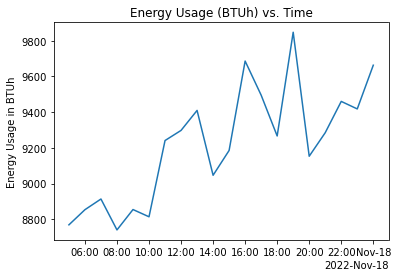

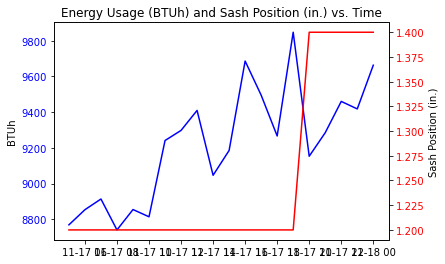

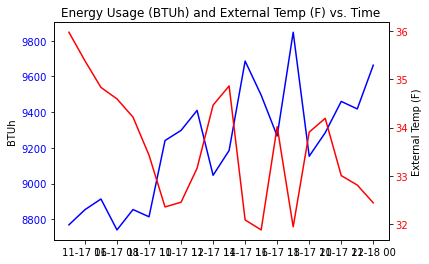

,cfm,sash,occ,internal temp,external temp,BTUh


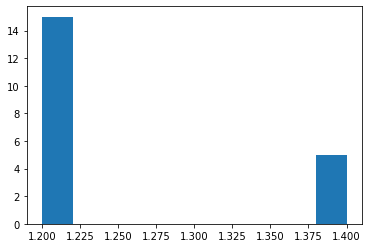

,cfm,sash,occ,internal temp,external temp,BTUh
2022-11-17 06:00:00,222.66,1.2,0.0,72.2,35.3840,8853.246605
2022-11-17 07:00:00,227.55,1.2,0.0,71.1,34.8314,8913.153524
2022-11-17 08:00:00,224.13,1.2,0.0,70.7,34.5938,8739.881214
2022-11-17 09:00:00,226.57,1.2,0.0,70.4,34.2158,8854.114530
2022-11-17 10:00:00,220.71,1.2,0.0,70.4,33.4256,8813.469410
2022-11-17 12:00:00,222.17,1.2,0.0,71.2,32.4500,9297.814500
2022-11-17 22:00:00,224.62,1.4,0.0,72.0,33.0026,9460.363667


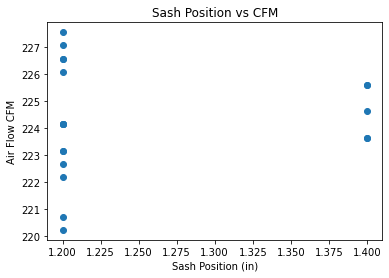

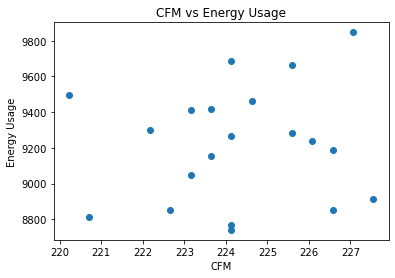

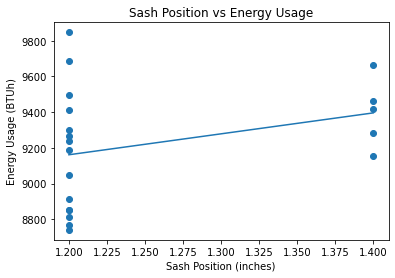

(0.31903252840950014, 0.1703644838916329)


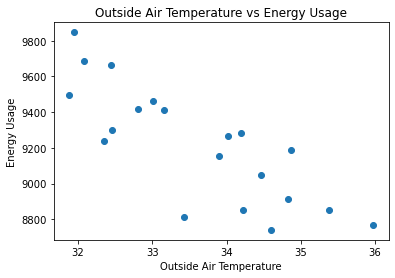

Variable: cfm(0.1078445892763949, 0.6508621314866362)
Variable: sash(0.31903252840950014, 0.1703644838916329)
Variable: occ(0.5291092589550178, 0.016445653200264306)
Variable: internal temp(0.4475112168315511, 0.04787105107189109)
Variable: external temp(-0.81194183251789, 1.380515368400028e-05)
Variable: BTUh(1.0, 0.0)


In [6]:
from datetime import datetime
from dateutil import parser
import matplotlib.dates as mdates
"""
Requires:
target_list: A python list filled with target strings
len(target_list) = 3 
target_list[0] should represent the CFM target
target_list[1] should represent the internal air setpoint target
target_list[2] should represent the occupancy target
target_list[3] should represent the sash position 

server: the server where the target is stored (string)
start: start_time (string)
end: end_time (string)

Returns: Energy Usage by fumehood in btus over set target period
"""

def query(target_list, server, start, end):
  cfm_master = fume_query(target_list[0],server,start,end)
  sash_master = fume_query(target_list[3],server,start,end)
  occ_master = fume_query(target_list[2],server,start,end)
  internal_temp_master = fume_query(target_list[1],server,start,end)
  external_temp_master = outside_temp(start,end)

  cfm_list = pd.Series(data=[i[0] for i in cfm_master], index=[i[1] for i in cfm_master])
  print("CFM List: ", cfm_list)
  cfm_list = cfm_list[~cfm_list.index.duplicated()]
  print("CFM List new: ", cfm_list)

  sash_list = pd.Series(data=[i[0] for i in sash_master], index=[i[1] for i in sash_master])
  print("\nSash List: ", sash_list)
  sash_list = sash_list[~sash_list.index.duplicated()]
  print("\nSash List new: ", sash_list)

  occ_list = pd.Series(data=[i[0] for i in occ_master], index=[i[1] for i in occ_master])
  print("\nOCC List: ", occ_list)
  occ_list = occ_list[~occ_list.index.duplicated()]
  print("\nOCC List new: ", occ_list)
  
  internal_temp_list = pd.Series(data=[i[0] for i in internal_temp_master], index=[i[1] for i in internal_temp_master])
  print("\nInternal Temp List: ", internal_temp_list)
  internal_temp_list = internal_temp_list[~internal_temp_list.index.duplicated()]
  print("\nInternal Temp List new: ", internal_temp_list)

  external_temp_list = pd.Series(data=[i[0] for i in external_temp_master], index=[i[1] for i in external_temp_master])
  print("\nExternal Temp List: ", external_temp_list)
  # external_temp_list = pd.read_csv("C:/Users/Dan/Documents/GitHub/fume-hood-dashboard/game_farm/hist.csv", index_col=0).squeeze()
  external_temp_list.index = external_temp_list.index.astype('datetime64[ns]')
  print("\nExternal Temp List: ", external_temp_list)

  df = pd.concat([cfm_list, sash_list, occ_list, internal_temp_list, external_temp_list], axis=1)
  df.columns = ["cfm", "sash" ,"occ", "internal temp", "external temp"]
  display(df)

  df = df.dropna()
  display(df)

  df["BTUh"] = 1.08 * df["cfm"] * (df["internal temp"] - df["external temp"])

  display(df)
  
  # convert_dates = np.vectorize(lambda s: parser.parse(s))
  # convert_dates(external_temp_list)

  # external_temp_list_resampled = pd.Series(data=external_temp_list, index=external_temp_list_dates).resample("5T").asfreq()
  # print(external_temp_list_resampled)

  # yourdate = parser.parse([i[1] for i in cfmMaster][0].astype(str))

  #We should try to do this in 10 minute intervals...not exactly sure how tho

  print("Total BTUh: ", df["BTUh"].sum())
  print("Total BTUh occupied: ", df["BTUh"][df["occ"] == 1.0].sum())
  print("Total BTUh unoccupied: ", df["BTUh"][df["occ"] == 0].sum())
  print("Percent occupied: ", len(df[df["occ"] == 1.0]) / len(df))

  plt.plot(df["BTUh"], label="BTUh")
  plt.ylabel("Energy Usage in BTUh")
  plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(plt.gca().xaxis.get_major_locator()))
  plt.title("Energy Usage (BTUh) vs. Time")
  plt.show()

  fig, ax = plt.subplots()
  ax.plot(df["BTUh"], color="blue")
  ax.tick_params(axis="y", labelcolor="blue")
  ax.set_ylabel("BTUh")
  ax2 = ax.twinx()
  ax2.plot(df["sash"], color="red")
  ax2.tick_params(axis="y", labelcolor="red")
  ax2.set_ylabel("Sash Position (in.)")
  plt.title("Energy Usage (BTUh) and Sash Position (in.) vs. Time")
  plt.show()

  # fig, ax = plt.subplots()
  # ax.plot(df["BTUh"], color="blue")
  # ax.tick_params(axis="y", labelcolor="blue")
  # ax2 = ax.twinx()
  # ax2.plot(df["occ"], color="red")
  # ax2.tick_params(axis="y", labelcolor="red")
  # plt.show()

  fig, ax = plt.subplots()
  ax.plot(df["BTUh"], color="blue")
  ax.tick_params(axis="y", labelcolor="blue")
  ax.set_ylabel("BTUh")
  ax2 = ax.twinx()
  ax2.plot(df["external temp"], color="red")
  ax2.tick_params(axis="y", labelcolor="red")
  ax2.set_ylabel("External Temp (F)")
  plt.title("Energy Usage (BTUh) and External Temp (F) vs. Time")
  plt.show()

  display(df[df["BTUh"]>20000])

  plt.hist(df["sash"])
  plt.show()

  display(df[(df["occ"] == 0) & (df["sash"] < 3)])

  plt.scatter(df["sash"], df["cfm"])
  plt.title("Sash Position vs CFM")
  plt.xlabel("Sash Position (in)")
  plt.ylabel("Air Flow CFM")
  plt.show()

  plt.scatter(df["cfm"],df["BTUh"])
  plt.title("CFM vs Energy Usage")
  plt.xlabel("CFM")
  plt.ylabel("Energy Usage")
  plt.show()

  plt.scatter(df["sash"],df["BTUh"])
  m, b = np.polyfit(df["sash"], df["BTUh"], 1)
  plt.plot(df["sash"], m*df["sash"] + b)
  plt.title("Sash Position vs Energy Usage")
  plt.xlabel("Sash Position (inches)")
  plt.ylabel("Energy Usage (BTUh)")
  plt.show()

  plt.scatter(df["external temp"],df["BTUh"])
  plt.title("Outside Air Temperature vs Energy Usage")
  plt.xlabel("Outside Air Temperature")
  plt.ylabel("Energy Usage")

  pearson_r = st.pearsonr(df["sash"],df["BTUh"])
  print(pearson_r)
  plt.show()
  ndf = (df[df["BTUh"]>12000])

  
  for val in df.columns :
    print("Variable: " + str(val) + str(st.pearsonr(df[val],df["BTUh"])))
  return


target_list = ["#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hoodvalve_flow/trend_log",
               "#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/zone/zone_temp/trend_log",
               "#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/occ_trend",
               "#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash"]
server = "biotech_main"
start = str(datetime(2022, 11, 17))
end = str(datetime(2022, 11, 18))

query(target_list,server,start,end)

In [7]:
# UTILITY FUNCTION FOR GENERATING SPREADSHEET OF EXTERNAL TEMPS - DONT USE
from dateutil import rrule
 
# dates
start_date = datetime(2019, 11, 17)
end_date = datetime(2022, 12, 27)
# end_date = datetime(2020, 2, 27)

months = rrule.rrule(rrule.MONTHLY, dtstart=start_date, until=end_date)

master_series = pd.Series(data=None)
 
for index, val in enumerate(months):
    if(index<(len(list(months))-1)):
        print(str(months[index]))
        external_temp_master = outside_temp(start=str(months[index]), end=str(months[index+1]))
        tmp_series = pd.Series(data=[i[0] for i in external_temp_master], index=[i[1] for i in external_temp_master])
        master_series = pd.concat([master_series, tmp_series])

master_series = master_series[master_series > -100] # prevent ridiculosuly low temps
master_series[~master_series.index.duplicated()].to_csv("C:/Users/Dan/Documents/GitHub/fume-hood-dashboard/game_farm/hist.csv", header=False)

2019-11-17 00:00:00


<ipython-input-7-e4a2e0854dd6>:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  master_series = pd.Series(data=None)


<Response [200]>
2019-12-17 00:00:00
<Response [200]>
2020-01-17 00:00:00
<Response [200]>
2020-02-17 00:00:00
<Response [200]>
2020-03-17 00:00:00
<Response [200]>
2020-04-17 00:00:00
<Response [200]>
2020-05-17 00:00:00
<Response [200]>
2020-06-17 00:00:00
<Response [200]>
2020-07-17 00:00:00
<Response [200]>
2020-08-17 00:00:00
<Response [200]>
2020-09-17 00:00:00
<Response [200]>
2020-10-17 00:00:00
<Response [200]>
2020-11-17 00:00:00
<Response [200]>
2020-12-17 00:00:00
<Response [200]>
2021-01-17 00:00:00
<Response [200]>
2021-02-17 00:00:00
<Response [200]>
2021-03-17 00:00:00
<Response [200]>
2021-04-17 00:00:00
<Response [200]>
2021-05-17 00:00:00
<Response [200]>
2021-06-17 00:00:00
<Response [200]>
2021-07-17 00:00:00
<Response [200]>
2021-08-17 00:00:00
<Response [200]>
2021-09-17 00:00:00
<Response [200]>
2021-10-17 00:00:00
<Response [200]>
2021-11-17 00:00:00
<Response [200]>
2021-12-17 00:00:00
<Response [200]>
2022-01-17 00:00:00
<Response [200]>
2022-02-17 00:00:00
<

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Dan/Documents/GitHub/fume-hood-dashboard/game_farm/hist.csv'

In [10]:
def get_data_by_occupancy(start, end, is_occupied):
    filtered_data = []
    for row in target_list:
        if start <= row[0] <= end:
            if is_occupied and row[1] == "occupied":
                filtered_data.append(row)
            elif not is_occupied and row[1] == "unoccupied":
                filtered_data.append(row)


In [11]:
occupied_data = get_data_by_occupancy(start, end, is_occupied=True)
unoccupied_data = get_data_by_occupancy(start, end, is_occupied=False)

RecursionError: maximum recursion depth exceeded in comparison